In [ ]:
import pandas as pd
import numpy as np

import os
import sys

import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report

import torch
import torchaudio
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from transformers import ASTForAudioClassification, AutoProcessor
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from sklearn.metrics import f1_score
from sklearn.utils.class_weight import compute_class_weight



In [2]:
Ravdess = "/mnt/c/Users/rubom/Desktop/Emotions DataSets/Ravdess/"
Crema   = "/mnt/c/Users/rubom/Desktop/Emotions DataSets/Crema/AudioWAV/"
Tess    = "/mnt/c/Users/rubom/Desktop/Emotions DataSets/Tess/TESS Toronto emotional speech set data/"
Savee   = "/mnt/c/Users/rubom/Desktop/Emotions DataSets/Savee/ALL/"

In [ ]:

ravdess_directory_list = [d for d in os.listdir(Ravdess) if d.startswith("Actor_")]

file_emotion = []
file_path = []

for dir in ravdess_directory_list:
    actor_folder = os.path.join(Ravdess, dir)
    
    for file in os.listdir(actor_folder):
        if not file.endswith('.wav'):
            continue  
        
        part = file.split('.')[0].split('-')
        
        if len(part) != 7:
            print(f"⚠️ Skipping malformed file: {file}")
            continue
        
        try:
            emotion_code = int(part[2])
            file_emotion.append(emotion_code)
            file_path.append(os.path.join(actor_folder, file))
        except ValueError:
            print(f"❌ Couldn't parse emotion code in: {file}")

emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])
path_df = pd.DataFrame(file_path, columns=['Path'])
Ravdess_df = pd.concat([emotion_df, path_df], axis=1)

emotion_labels = {
    1: 'neutral',
    2: 'calm',
    3: 'happy',
    4: 'sad',
    5: 'angry',
    6: 'fear',
    7: 'disgust',
    8: 'surprise'
}
Ravdess_df["Emotions"] = Ravdess_df["Emotions"].map(emotion_labels)

print(Ravdess_df.head())
print(Ravdess_df["Path"].values[1])

  Emotions                                               Path
0  neutral  /mnt/c/Users/rubom/Desktop/Emotions DataSets/R...
1  neutral  /mnt/c/Users/rubom/Desktop/Emotions DataSets/R...
2  neutral  /mnt/c/Users/rubom/Desktop/Emotions DataSets/R...
3  neutral  /mnt/c/Users/rubom/Desktop/Emotions DataSets/R...
4     calm  /mnt/c/Users/rubom/Desktop/Emotions DataSets/R...
/mnt/c/Users/rubom/Desktop/Emotions DataSets/Ravdess/Actor_01/03-01-01-01-01-02-01.wav


In [ ]:
crema_directory_list = os.listdir(Crema)

file_emotion = []
file_path = []

for file in crema_directory_list:

    file_path.append(Crema + file)

    part=file.split('_')
    if part[2] == 'SAD':
        file_emotion.append('sad')
    elif part[2] == 'ANG':
        file_emotion.append('angry')
    elif part[2] == 'DIS':
        file_emotion.append('disgust')
    elif part[2] == 'FEA':
        file_emotion.append('fear')
    elif part[2] == 'HAP':
        file_emotion.append('happy')
    elif part[2] == 'NEU':
        file_emotion.append('neutral')
    else:
        file_emotion.append('Unknown')
        

emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

path_df = pd.DataFrame(file_path, columns=['Path'])
Crema_df = pd.concat([emotion_df, path_df], axis=1)
Crema_df.head()
print(Crema_df["Path"].values[1])

/mnt/c/Users/rubom/Desktop/Emotions DataSets/Crema/AudioWAV/1001_DFA_DIS_XX.wav


In [ ]:
tess_directory_list = os.listdir(Tess)
file_emotion = []
file_path = []

for dir in tess_directory_list:
    directories = os.listdir(Tess + "/"+dir)
    for file in directories:
        part = file.split('.')[0]
        part = part.split('_')[2]

        if part=='ps':
            file_emotion.append('surprise')
        else:
            file_emotion.append(part)
        file_path.append(Tess + dir + '/' + file)
        

emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

path_df = pd.DataFrame(file_path, columns=['Path'])
Tess_df = pd.concat([emotion_df, path_df], axis=1)
Tess_df.head()
print(Tess_df['Path'].values[1])

/mnt/c/Users/rubom/Desktop/Emotions DataSets/Tess/TESS Toronto emotional speech set data/OAF_angry/OAF_bar_angry.wav


In [ ]:
savee_directory_list = os.listdir(Savee)

file_emotion = []
file_path = []

for file in savee_directory_list:
    file_path.append(Savee + file)
    part = file.split('_')[1]
    ele = part[:-6]
    if ele=='a':
        file_emotion.append('angry')
    elif ele=='d':
        file_emotion.append('disgust')
    elif ele=='f':
        file_emotion.append('fear')
    elif ele=='h':
        file_emotion.append('happy')
    elif ele=='n':
        file_emotion.append('neutral')
    elif ele=='sa':
        file_emotion.append('sad')
    else:
        file_emotion.append('surprise')
        

emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

path_df = pd.DataFrame(file_path, columns=['Path'])
Savee_df = pd.concat([emotion_df, path_df], axis=1)
Savee_df.head()
print(Savee_df["Path"].values[1])

/mnt/c/Users/rubom/Desktop/Emotions DataSets/Savee/ALL/DC_a02.wav


In [7]:
data_path = pd.concat([Ravdess_df, Crema_df, Tess_df, Savee_df], axis = 0)
data_path.to_csv("data_path.csv",index=False)
data_path

,Emotions,Path
0,neutral,/mnt/c/Users/rubom/Desktop/Emotions DataSets/R...
1,neutral,/mnt/c/Users/rubom/Desktop/Emotions DataSets/R...
2,neutral,/mnt/c/Users/rubom/Desktop/Emotions DataSets/R...
3,neutral,/mnt/c/Users/rubom/Desktop/Emotions DataSets/R...
4,calm,/mnt/c/Users/rubom/Desktop/Emotions DataSets/R...
...,...,...
475,surprise,/mnt/c/Users/rubom/Desktop/Emotions DataSets/S...
476,surprise,/mnt/c/Users/rubom/Desktop/Emotions DataSets/S...
477,surprise,/mnt/c/Users/rubom/Desktop/Emotions DataSets/S...
478,surprise,/mnt/c/Users/rubom/Desktop/Emotions DataSets/S...


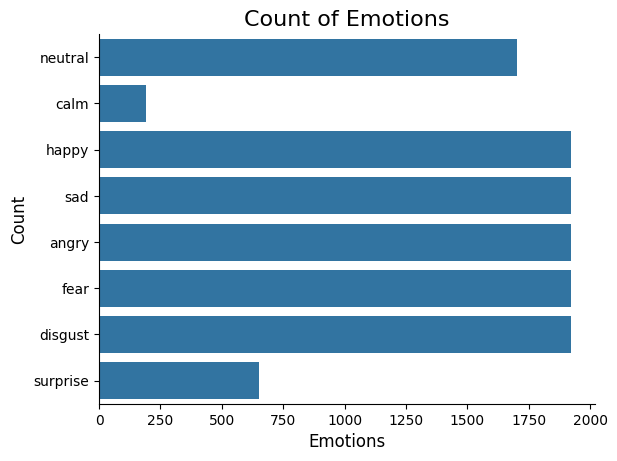

In [8]:
plt.title('Count of Emotions', size=16)
sns.countplot(data_path.Emotions)
plt.ylabel('Count', size=12)
plt.xlabel('Emotions', size=12)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()

Some weights of ASTForAudioClassification were not initialized from the model checkpoint at MIT/ast-finetuned-speech-commands-v2 and are newly initialized because the shapes did not match:
- classifier.dense.bias: found shape torch.Size([35]) in the checkpoint and torch.Size([8]) in the model instantiated
- classifier.dense.weight: found shape torch.Size([35, 768]) in the checkpoint and torch.Size([8, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_634/2284507888.py:261: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be fl

✅ Loaded checkpoint from epoch 52

Epoch 53/75


Epoch 53, Loss: 1.5794, Accuracy: 65.86%


Validation Loss: 1.6675, Accuracy: 56.50%
F1 Score: 0.5599
              precision    recall  f1-score   support

       angry     0.6833    0.7489    0.7146      1155
        calm     0.2494    0.9561    0.3956       114
     disgust     0.5538    0.3922    0.4592      1155
        fear     0.6086    0.3784    0.4666      1155
       happy     0.5791    0.4788    0.5242      1155
     neutral     0.5406    0.6657    0.5967      1020
         sad     0.5456    0.6216    0.5811      1155
    surprise     0.5816    0.7949    0.6717       390

    accuracy                         0.5650      7299
   macro avg     0.5427    0.6296    0.5512      7299
weighted avg     0.5805    0.5650    0.5599      7299

✅ Checkpoint saved at epoch 53

Epoch 54/75


Epoch 54, Loss: 1.5765, Accuracy: 66.18%


Validation Loss: 1.6668, Accuracy: 56.19%
F1 Score: 0.5570
              precision    recall  f1-score   support

       angry     0.6649    0.7558    0.7075      1155
        calm     0.2478    0.9825    0.3958       114
     disgust     0.6182    0.3532    0.4496      1155
        fear     0.5150    0.4468    0.4784      1155
       happy     0.5890    0.4528    0.5120      1155
     neutral     0.5191    0.6941    0.5940      1020
         sad     0.5717    0.5697    0.5707      1155
    surprise     0.6461    0.7769    0.7055       390

    accuracy                         0.5619      7299
   macro avg     0.5464    0.6290    0.5517      7299
weighted avg     0.5791    0.5619    0.5570      7299

✅ Checkpoint saved at epoch 54

Epoch 55/75


Epoch 55, Loss: 1.5747, Accuracy: 66.28%


Validation Loss: 1.6682, Accuracy: 56.14%
F1 Score: 0.5584
              precision    recall  f1-score   support

       angry     0.6859    0.7411    0.7124      1155
        calm     0.2627    0.9561    0.4121       114
     disgust     0.5703    0.3896    0.4630      1155
        fear     0.5070    0.4407    0.4715      1155
       happy     0.5770    0.4771    0.5223      1155
     neutral     0.5785    0.6108    0.5942      1020
         sad     0.5410    0.5991    0.5686      1155
    surprise     0.5789    0.7897    0.6681       390

    accuracy                         0.5614      7299
   macro avg     0.5377    0.6255    0.5515      7299
weighted avg     0.5718    0.5614    0.5584      7299

✅ Checkpoint saved at epoch 55

Epoch 56/75


Epoch 56, Loss: 1.5746, Accuracy: 66.54%


Validation Loss: 1.6678, Accuracy: 56.34%
F1 Score: 0.5591
              precision    recall  f1-score   support

       angry     0.6641    0.7567    0.7074      1155
        calm     0.2603    0.9386    0.4076       114
     disgust     0.5774    0.3810    0.4591      1155
        fear     0.5234    0.4364    0.4759      1155
       happy     0.5805    0.4745    0.5222      1155
     neutral     0.5600    0.6314    0.5935      1020
         sad     0.5535    0.5957    0.5738      1155
    surprise     0.6020    0.7872    0.6822       390

    accuracy                         0.5634      7299
   macro avg     0.5402    0.6252    0.5527      7299
weighted avg     0.5732    0.5634    0.5591      7299

✅ Checkpoint saved at epoch 56

Epoch 57/75


Epoch 57, Loss: 1.5731, Accuracy: 66.73%


Validation Loss: 1.6657, Accuracy: 56.50%
F1 Score: 0.5607
              precision    recall  f1-score   support

       angry     0.7064    0.7186    0.7124      1155
        calm     0.2500    0.9825    0.3986       114
     disgust     0.6200    0.3602    0.4556      1155
        fear     0.5820    0.3965    0.4717      1155
       happy     0.5763    0.4874    0.5281      1155
     neutral     0.5329    0.6520    0.5864      1020
         sad     0.5106    0.6701    0.5796      1155
    surprise     0.6415    0.7846    0.7059       390

    accuracy                         0.5650      7299
   macro avg     0.5524    0.6315    0.5548      7299
weighted avg     0.5866    0.5650    0.5607      7299

✅ Checkpoint saved at epoch 57

Epoch 58/75


Epoch 58, Loss: 1.5714, Accuracy: 66.81%


Validation Loss: 1.6656, Accuracy: 56.45%
F1 Score: 0.5586
              precision    recall  f1-score   support

       angry     0.6596    0.7567    0.7048      1155
        calm     0.2506    0.9649    0.3978       114
     disgust     0.6122    0.3567    0.4508      1155
        fear     0.5434    0.4173    0.4721      1155
       happy     0.5877    0.4641    0.5186      1155
     neutral     0.5509    0.6627    0.6017      1020
         sad     0.5450    0.6242    0.5819      1155
    surprise     0.6023    0.7923    0.6844       390

    accuracy                         0.5645      7299
   macro avg     0.5440    0.6299    0.5515      7299
weighted avg     0.5796    0.5645    0.5586      7299

✅ Checkpoint saved at epoch 58

Epoch 59/75


Epoch 59, Loss: 1.5697, Accuracy: 66.98%


Validation Loss: 1.6654, Accuracy: 56.67%
F1 Score: 0.5629
              precision    recall  f1-score   support

       angry     0.6929    0.7403    0.7158      1155
        calm     0.2511    0.9649    0.3986       114
     disgust     0.6082    0.3602    0.4524      1155
        fear     0.5233    0.4571    0.4880      1155
       happy     0.6172    0.4537    0.5230      1155
     neutral     0.5144    0.7010    0.5934      1020
         sad     0.5507    0.5974    0.5731      1155
    surprise     0.6742    0.7641    0.7163       390

    accuracy                         0.5667      7299
   macro avg     0.5540    0.6298    0.5576      7299
weighted avg     0.5853    0.5667    0.5629      7299

✅ Checkpoint saved at epoch 59

Epoch 60/75


Epoch 60, Loss: 1.5681, Accuracy: 67.17%


Validation Loss: 1.6648, Accuracy: 56.75%
F1 Score: 0.5617
              precision    recall  f1-score   support

       angry     0.6695    0.7506    0.7078      1155
        calm     0.2489    0.9825    0.3972       114
     disgust     0.6084    0.3619    0.4539      1155
        fear     0.5725    0.3965    0.4685      1155
       happy     0.5976    0.4693    0.5257      1155
     neutral     0.5465    0.6627    0.5990      1020
         sad     0.5222    0.6606    0.5833      1155
    surprise     0.6623    0.7846    0.7183       390

    accuracy                         0.5675      7299
   macro avg     0.5535    0.6336    0.5567      7299
weighted avg     0.5857    0.5675    0.5617      7299

✅ Checkpoint saved at epoch 60

Epoch 61/75


Epoch 61, Loss: 1.5665, Accuracy: 67.40%


Validation Loss: 1.6659, Accuracy: 56.31%
F1 Score: 0.5594
              precision    recall  f1-score   support

       angry     0.7154    0.7290    0.7221      1155
        calm     0.2434    0.9737    0.3895       114
     disgust     0.6413    0.3359    0.4409      1155
        fear     0.5444    0.4190    0.4736      1155
       happy     0.5543    0.5212    0.5373      1155
     neutral     0.5384    0.6324    0.5816      1020
         sad     0.5202    0.6355    0.5721      1155
    surprise     0.6373    0.7795    0.7013       390

    accuracy                         0.5631      7299
   macro avg     0.5493    0.6283    0.5523      7299
weighted avg     0.5840    0.5631    0.5594      7299

✅ Checkpoint saved at epoch 61

Epoch 62/75


Epoch 62, Loss: 1.5653, Accuracy: 67.32%


Validation Loss: 1.6627, Accuracy: 56.79%
F1 Score: 0.5655
              precision    recall  f1-score   support

       angry     0.6959    0.7290    0.7121      1155
        calm     0.2581    0.9825    0.4088       114
     disgust     0.5954    0.3784    0.4627      1155
        fear     0.5292    0.4398    0.4804      1155
       happy     0.5514    0.5247    0.5377      1155
     neutral     0.5448    0.6559    0.5952      1020
         sad     0.5659    0.5801    0.5729      1155
    surprise     0.6689    0.7718    0.7167       390

    accuracy                         0.5679      7299
   macro avg     0.5512    0.6328    0.5608      7299
weighted avg     0.5808    0.5679    0.5655      7299

✅ Checkpoint saved at epoch 62

Epoch 63/75


Epoch 63, Loss: 1.5628, Accuracy: 67.84%


Validation Loss: 1.6628, Accuracy: 57.16%
F1 Score: 0.5652
              precision    recall  f1-score   support

       angry     0.6787    0.7481    0.7117      1155
        calm     0.2551    0.9825    0.4051       114
     disgust     0.6439    0.3429    0.4475      1155
        fear     0.5940    0.3939    0.4737      1155
       happy     0.5776    0.5091    0.5412      1155
     neutral     0.5400    0.6814    0.6025      1020
         sad     0.5254    0.6537    0.5826      1155
    surprise     0.6616    0.7872    0.7190       390

    accuracy                         0.5716      7299
   macro avg     0.5595    0.6373    0.5604      7299
weighted avg     0.5926    0.5716    0.5652      7299

✅ Checkpoint saved at epoch 63

Epoch 64/75


Epoch 64, Loss: 1.5621, Accuracy: 67.99%


Validation Loss: 1.6633, Accuracy: 56.88%
F1 Score: 0.5651
              precision    recall  f1-score   support

       angry     0.6926    0.7411    0.7160      1155
        calm     0.2413    0.9737    0.3868       114
     disgust     0.5689    0.3931    0.4649      1155
        fear     0.6089    0.3801    0.4680      1155
       happy     0.5920    0.4874    0.5347      1155
     neutral     0.5372    0.6647    0.5942      1020
         sad     0.5295    0.6519    0.5844      1155
    surprise     0.6637    0.7641    0.7104       390

    accuracy                         0.5688      7299
   macro avg     0.5543    0.6320    0.5574      7299
weighted avg     0.5877    0.5688    0.5651      7299

✅ Checkpoint saved at epoch 64

Epoch 65/75


Epoch 65, Loss: 1.5603, Accuracy: 68.10%


Validation Loss: 1.6649, Accuracy: 56.75%
F1 Score: 0.5651
              precision    recall  f1-score   support

       angry     0.6853    0.7411    0.7121      1155
        calm     0.2625    0.9649    0.4128       114
     disgust     0.5707    0.3913    0.4643      1155
        fear     0.5238    0.4294    0.4719      1155
       happy     0.5467    0.5316    0.5391      1155
     neutral     0.5988    0.5912    0.5950      1020
         sad     0.5426    0.6173    0.5776      1155
    surprise     0.6652    0.7641    0.7112       390

    accuracy                         0.5675      7299
   macro avg     0.5495    0.6289    0.5605      7299
weighted avg     0.5773    0.5675    0.5651      7299

✅ Checkpoint saved at epoch 65

Epoch 66/75


Epoch 66, Loss: 1.5593, Accuracy: 68.31%


Validation Loss: 1.6629, Accuracy: 56.82%
F1 Score: 0.5640
              precision    recall  f1-score   support

       angry     0.6698    0.7515    0.7083      1155
        calm     0.2651    0.9649    0.4159       114
     disgust     0.6064    0.3749    0.4633      1155
        fear     0.5356    0.4294    0.4767      1155
       happy     0.5407    0.5290    0.5348      1155
     neutral     0.5755    0.6088    0.5917      1020
         sad     0.5634    0.6000    0.5811      1155
    surprise     0.6189    0.8077    0.7008       390

    accuracy                         0.5682      7299
   macro avg     0.5469    0.6333    0.5591      7299
weighted avg     0.5791    0.5682    0.5640      7299

✅ Checkpoint saved at epoch 66

Epoch 67/75


Epoch 67, Loss: 1.5571, Accuracy: 68.47%


Validation Loss: 1.6630, Accuracy: 56.97%
F1 Score: 0.5645
              precision    recall  f1-score   support

       angry     0.6494    0.7619    0.7012      1155
        calm     0.2646    0.9561    0.4144       114
     disgust     0.5892    0.3887    0.4684      1155
        fear     0.5807    0.4113    0.4815      1155
       happy     0.5760    0.4857    0.5270      1155
     neutral     0.5416    0.6637    0.5965      1020
         sad     0.5584    0.6087    0.5824      1155
    surprise     0.6482    0.7795    0.7078       390

    accuracy                         0.5697      7299
   macro avg     0.5510    0.6320    0.5599      7299
weighted avg     0.5819    0.5697    0.5645      7299

✅ Checkpoint saved at epoch 67

Epoch 68/75


Epoch 68, Loss: 1.5567, Accuracy: 68.69%


Validation Loss: 1.6638, Accuracy: 56.77%
F1 Score: 0.5635
              precision    recall  f1-score   support

       angry     0.6598    0.7524    0.7031      1155
        calm     0.2683    0.9649    0.4198       114
     disgust     0.6014    0.3827    0.4677      1155
        fear     0.5550    0.4190    0.4776      1155
       happy     0.5465    0.5134    0.5295      1155
     neutral     0.5638    0.6147    0.5882      1020
         sad     0.5426    0.6182    0.5779      1155
    surprise     0.6748    0.7821    0.7245       390

    accuracy                         0.5677      7299
   macro avg     0.5515    0.6309    0.5610      7299
weighted avg     0.5788    0.5677    0.5635      7299

✅ Checkpoint saved at epoch 68

Epoch 69/75


Epoch 69, Loss: 1.5542, Accuracy: 68.76%


Validation Loss: 1.6641, Accuracy: 56.91%
F1 Score: 0.5661
              precision    recall  f1-score   support

       angry     0.7106    0.7229    0.7167      1155
        calm     0.2680    0.9123    0.4143       114
     disgust     0.6003    0.3784    0.4642      1155
        fear     0.5286    0.4407    0.4806      1155
       happy     0.5501    0.5177    0.5335      1155
     neutral     0.5577    0.6353    0.5940      1020
         sad     0.5510    0.6173    0.5823      1155
    surprise     0.6175    0.7949    0.6951       390

    accuracy                         0.5691      7299
   macro avg     0.5480    0.6274    0.5601      7299
weighted avg     0.5804    0.5691    0.5661      7299

✅ Checkpoint saved at epoch 69

Epoch 70/75


Epoch 70, Loss: 1.5535, Accuracy: 68.85%


Validation Loss: 1.6617, Accuracy: 57.06%
F1 Score: 0.5679
              precision    recall  f1-score   support

       angry     0.7161    0.7143    0.7152      1155
        calm     0.2657    0.9649    0.4167       114
     disgust     0.5981    0.3775    0.4628      1155
        fear     0.5406    0.4320    0.4803      1155
       happy     0.5519    0.5290    0.5402      1155
     neutral     0.5353    0.6765    0.5977      1020
         sad     0.5573    0.5939    0.5750      1155
    surprise     0.6784    0.7897    0.7299       390

    accuracy                         0.5706      7299
   macro avg     0.5554    0.6347    0.5647      7299
weighted avg     0.5842    0.5706    0.5679      7299

✅ Checkpoint saved at epoch 70

Epoch 71/75


Epoch 71, Loss: 1.5531, Accuracy: 69.13%


Validation Loss: 1.6605, Accuracy: 57.06%
F1 Score: 0.5679
              precision    recall  f1-score   support

       angry     0.7150    0.7169    0.7160      1155
        calm     0.2517    0.9737    0.4000       114
     disgust     0.5641    0.3922    0.4627      1155
        fear     0.5622    0.4225    0.4825      1155
       happy     0.6004    0.4814    0.5344      1155
     neutral     0.5285    0.7000    0.6023      1020
         sad     0.5492    0.6087    0.5774      1155
    surprise     0.6610    0.8000    0.7239       390

    accuracy                         0.5706      7299
   macro avg     0.5540    0.6369    0.5624      7299
weighted avg     0.5864    0.5706    0.5679      7299

✅ Checkpoint saved at epoch 71

Epoch 72/75


Epoch 72, Loss: 1.5507, Accuracy: 69.25%


Validation Loss: 1.6624, Accuracy: 56.75%
F1 Score: 0.5639
              precision    recall  f1-score   support

       angry     0.6803    0.7368    0.7074      1155
        calm     0.2686    0.9825    0.4218       114
     disgust     0.5916    0.3775    0.4609      1155
        fear     0.5287    0.4381    0.4792      1155
       happy     0.5717    0.5074    0.5376      1155
     neutral     0.5687    0.6127    0.5899      1020
         sad     0.5361    0.6173    0.5738      1155
    surprise     0.6480    0.8026    0.7171       390

    accuracy                         0.5675      7299
   macro avg     0.5492    0.6344    0.5610      7299
weighted avg     0.5785    0.5675    0.5639      7299

✅ Checkpoint saved at epoch 72

Epoch 73/75


Epoch 73, Loss: 1.5500, Accuracy: 69.46%


Validation Loss: 1.6610, Accuracy: 57.14%
F1 Score: 0.5688
              precision    recall  f1-score   support

       angry     0.6931    0.7351    0.7134      1155
        calm     0.2675    0.9737    0.4197       114
     disgust     0.5547    0.4173    0.4763      1155
        fear     0.5398    0.4407    0.4852      1155
       happy     0.6141    0.4684    0.5314      1155
     neutral     0.5464    0.6520    0.5945      1020
         sad     0.5534    0.6104    0.5805      1155
    surprise     0.6505    0.7923    0.7145       390

    accuracy                         0.5714      7299
   macro avg     0.5524    0.6362    0.5644      7299
weighted avg     0.5829    0.5714    0.5688      7299

✅ Checkpoint saved at epoch 73

Epoch 74/75


Epoch 74, Loss: 1.5485, Accuracy: 69.57%


Validation Loss: 1.6606, Accuracy: 57.24%
F1 Score: 0.5689
              precision    recall  f1-score   support

       angry     0.6742    0.7489    0.7096      1155
        calm     0.2643    0.9737    0.4157       114
     disgust     0.5625    0.4052    0.4711      1155
        fear     0.5594    0.4320    0.4875      1155
       happy     0.5940    0.4814    0.5318      1155
     neutral     0.5613    0.6333    0.5951      1020
         sad     0.5495    0.6251    0.5849      1155
    surprise     0.6603    0.7974    0.7224       390

    accuracy                         0.5724      7299
   macro avg     0.5532    0.6371    0.5648      7299
weighted avg     0.5830    0.5724    0.5689      7299

✅ Checkpoint saved at epoch 74

Epoch 75/75


Epoch 75, Loss: 1.5474, Accuracy: 69.58%


Validation Loss: 1.6608, Accuracy: 57.19%
F1 Score: 0.5677
              precision    recall  f1-score   support

       angry     0.6685    0.7472    0.7056      1155
        calm     0.2638    0.9649    0.4143       114
     disgust     0.5857    0.3818    0.4623      1155
        fear     0.5618    0.4208    0.4812      1155
       happy     0.5620    0.5177    0.5390      1155
     neutral     0.5519    0.6569    0.5998      1020
         sad     0.5639    0.6035    0.5830      1155
    surprise     0.6732    0.7923    0.7279       390

    accuracy                         0.5719      7299
   macro avg     0.5539    0.6356    0.5641      7299
weighted avg     0.5827    0.5719    0.5677      7299

✅ Checkpoint saved at epoch 75
✅ Training complete!


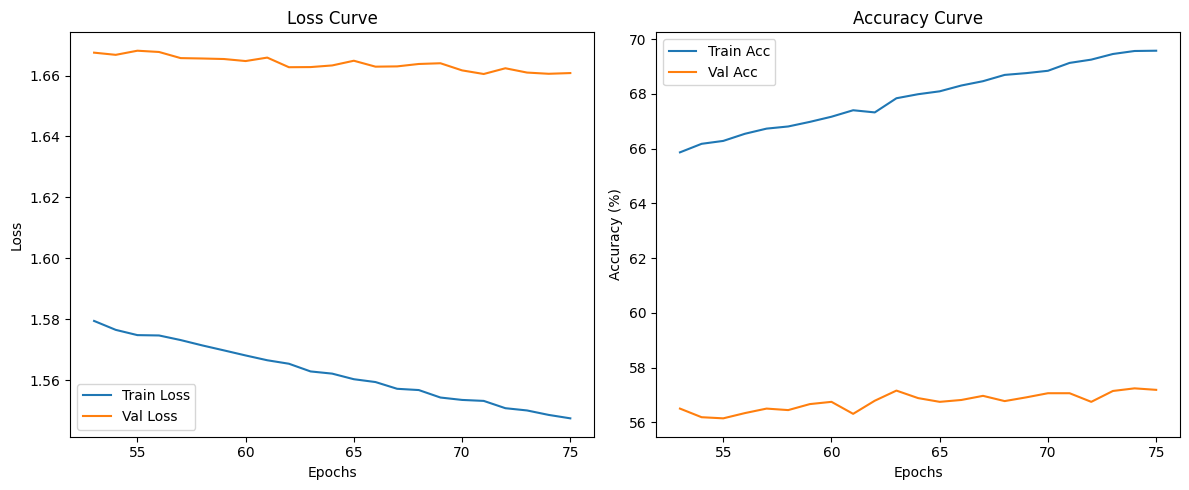

In [ ]:



def add_noise(data):
    noise_amp = 0.005 * np.random.uniform() * np.amax(data)
    return data + noise_amp * np.random.normal(size=data.shape)

def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(y=data, rate=rate)

def pitch(data, sr, steps=4):
    return librosa.effects.pitch_shift(y=data, sr=sr, n_steps=steps)


# ========== Dataset ==========
class EmotionAudioDataset(Dataset):
    def __init__(self, dataframe, processor_name="MIT/ast-finetuned-speech-commands-v2", train=True):
        df = dataframe.copy().dropna().reset_index(drop=True)

        # Encode emotions to integers
        self.label_map = {emotion: i for i, emotion in enumerate(sorted(df["Emotions"].unique()))}
        self.df = df.copy()
        self.df["label"] = self.df["Emotions"].map(self.label_map)
        
        # Stratified split
        train_df, val_df = train_test_split(self.df, test_size=0.2, stratify=self.df["label"], random_state=42)

        
        self.df = train_df if train else val_df
             # Step 2: Augment training set
        augmented_rows_train = []
        for _, row in self.df.iterrows():
            for aug_type in ["original", "noise", "stretch_pitch"]:
                augmented_rows_train.append({
                    "Path": row["Path"],
                    "Emotions": row["Emotions"],
                    "label": row["label"],  # <-- ЭТО ВАЖНО
                    "AugType": aug_type
                })
        self.df = pd.DataFrame(augmented_rows_train)

        self.processor = AutoProcessor.from_pretrained(processor_name)

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        file_path = row["Path"]
        label = row["label"]
        aug_type = row["AugType"]

        try:
            waveform, sample_rate = torchaudio.load(file_path)
        except Exception as e:
            print(f"❌ Error loading {file_path}: {e}")
            return torch.zeros((128, 128)), torch.tensor(0)
        
        if waveform.shape[0] > 1:
            waveform = waveform.mean(dim=0)
        waveform = waveform.squeeze().numpy()

        # Apply augmentation
        if aug_type == "noise":
            waveform = add_noise(waveform)
        elif aug_type == "stretch_pitch":
            waveform = stretch(waveform)
            waveform = pitch(waveform, sample_rate)

        # Resample if needed
        if sample_rate != 16000:
            waveform = librosa.resample(waveform, orig_sr=sample_rate, target_sr=16000)
            sample_rate = 16000

        # Back to tensor
        waveform = torch.tensor(waveform)

        try:
            processed = self.processor(
                waveform,
                sampling_rate=16000,
                return_tensors="pt",
                padding="max_length",
                max_length=16000
            )
            input_values = processed.input_values.squeeze(0)
        except Exception as e:
            print(f"❌ Error processing {file_path}: {e}")
            return torch.zeros((128, 128)), torch.tensor(0)

        return input_values, torch.tensor(label)

# ========== Classifier ==========
class CustomClassifier(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(CustomClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, 512)
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, num_classes)
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        return self.softmax(x)


def save_checkpoint(model, optimizer, epoch, path="checkpoints/checkpoint.pth"):
    os.makedirs(os.path.dirname(path), exist_ok=True)
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
    }, path)
    print(f"\u2705 Checkpoint saved at epoch {epoch}")

# ========== Training ==========
def train_model(model, train_loader, val_loader, label_map, num_epochs=10, learning_rate=2e-5, checkpoint_path=None):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    
    optimizer = optim.AdamW(model.classifier.parameters(), lr=learning_rate)
    
    # === Compute class weights for imbalance ===
    train_labels = train_loader.dataset.df["label"]
    # train_labels = []
    # for _, label in train_loader.dataset:
    #     train_labels.append(label.item())
    
    class_weights = compute_class_weight(
        class_weight='balanced',
        classes=np.unique(train_labels),
        y=train_labels
    )
    class_weights_tensor = torch.tensor(class_weights, dtype=torch.float).to(device)
    
    # Use weighted loss
    criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)

    train_losses, val_losses = [], []
    train_accs, val_accs = [], []

    start_epoch = 0
    if checkpoint_path and os.path.exists(checkpoint_path):
        start_epoch = load_checkpoint(model, optimizer, checkpoint_path)

    for epoch in range(start_epoch, num_epochs):
        model.train()
        total_loss = 0
        correct = 0
        total = 0

        print(f"\nEpoch {epoch+1}/{num_epochs}")
        train_bar = tqdm(train_loader, desc="Training", leave=False)

        for inputs, labels in train_bar:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()

            outputs = model(inputs).logits
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            _, predicted = outputs.max(1)
            correct += predicted.eq(labels).sum().item()
            total += labels.size(0)

            train_bar.set_postfix(loss=loss.item(), acc=100 * correct / total)

        train_loss = total_loss / len(train_loader)
        train_acc = 100 * correct / total
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        print(f"Epoch {epoch+1}, Loss: {train_loss:.4f}, Accuracy: {train_acc:.2f}%")

        # Validation
        model.eval()
        val_loss = 0
        correct = 0
        total = 0
        all_labels = []
        all_preds = []

        val_bar = tqdm(val_loader, desc="Validating", leave=False)
        with torch.no_grad():
            for inputs, labels in val_bar:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(input_values=inputs).logits

                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = outputs.max(1)
                correct += predicted.eq(labels).sum().item()
                total += labels.size(0)

                all_labels.extend(labels.cpu().numpy())
                all_preds.extend(predicted.cpu().numpy())

                val_bar.set_postfix(loss=loss.item(), acc=100 * correct / total)

        val_loss /= len(val_loader)
        val_acc = 100 * correct / total
        val_losses.append(val_loss)
        val_accs.append(val_acc)
        print(f"Validation Loss: {val_loss:.4f}, Accuracy: {val_acc:.2f}%")
        print(f"F1 Score: {f1_score(all_labels, all_preds, average='weighted'):.4f}")

        target_names = list(label_map.keys())
        print(classification_report(all_labels, all_preds, target_names=target_names, digits=4))

        save_checkpoint(model, optimizer, epoch + 1, path=f"checkpoints/epoch_{epoch+1}.pth")

    print("\u2705 Training complete!")

    # Plot and save curves
    total_epochs_ran = range(start_epoch + 1, start_epoch + len(train_losses) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(total_epochs_ran, train_losses, label='Train Loss')
    plt.plot(total_epochs_ran, val_losses, label='Val Loss')
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.title("Loss Curve")

    plt.subplot(1, 2, 2)
    plt.plot(total_epochs_ran, train_accs, label='Train Acc')
    plt.plot(total_epochs_ran, val_accs, label='Val Acc')
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy (%)")
    plt.legend()
    plt.title("Accuracy Curve")

    plt.tight_layout()
    plt.savefig("training_curves.png")
    plt.show()


def load_checkpoint(model, optimizer, path):
    checkpoint = torch.load(path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    print(f"\u2705 Loaded checkpoint from epoch {checkpoint['epoch']}")
    return checkpoint['epoch']

# ========== Main ==========
if __name__ == "__main__":



    train_dataset = EmotionAudioDataset(data_path, train=True)
    val_dataset = EmotionAudioDataset(data_path, train=False)


    

    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

    model = ASTForAudioClassification.from_pretrained(
        "MIT/ast-finetuned-speech-commands-v2",
        num_labels=len(train_dataset.label_map),
        ignore_mismatched_sizes=True
    )

    for param in model.parameters():
        param.requires_grad = True

    custom_clf = CustomClassifier(model.config.hidden_size, len(train_dataset.label_map))
    model.classifier = custom_clf

    for param in model.classifier.parameters():
        param.requires_grad = True

    train_model(
    model,
    train_loader,
    val_loader,
    label_map=train_dataset.label_map,
    num_epochs=75,  
    checkpoint_path="checkpoints/epoch_52.pth"
    )

    torch.save(model.state_dict(), "final_model_emotions_with_augmentation_state_dict.pth")
    torch.save(model, "final_model_emotions_with_augmentation.pth")